# NSGA-II Experiments: Half-Size Dataset (40 Tests, 124 Requirements)

This notebook runs NSGA-II experiments on the half-size dataset with:
- 40 test cases
- 124 requirements
- Budget levels from 5% to 95%
- 30 runs per budget level
- **Automatic checkpointing** for resuming interrupted experiments

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
import math
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime
import json
import os
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Dataset and Checkpoint Configuration

In [ ]:
# Dataset configuration
DATASET_NAME = "HalfSize_40-124"
DATA_PATH = 'your_40_124_data_path'  # Half-size dataset
OUTPUT_PREFIX = 'halfsize'  # Prefix for output files

# Checkpoint configuration
# For Google Colab with Drive mounted:
CHECKPOINT_DIR = '/your_40_124_checkpoint_directory_path'
# For local execution:
# CHECKPOINT_DIR = '.'  # Current directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_FILE = os.path.join(CHECKPOINT_DIR, f'{OUTPUT_PREFIX}_checkpoint.json')

# Experiment configuration
BUDGET_PERCENTAGES = list(range(5, 100, 5))  # 5%, 10%, 15%, ..., 95%
NUM_RUNS = 30
POP_SIZE = 100
GENERATIONS = 150
BASE_SEED = 42

print(f"Dataset: {DATASET_NAME}")
print(f"Data path: {DATA_PATH}")
print(f"Checkpoint file: {CHECKPOINT_FILE}")
print(f"Budget percentages: {BUDGET_PERCENTAGES}")
print(f"Runs per budget: {NUM_RUNS}")
print(f"Population size: {POP_SIZE}")
print(f"Generations: {GENERATIONS}")

Dataset: HalfSize_40-124
Data path: /content/drive/MyDrive/RTS/Dataset/mapped_dataset_1-half.xlsx
Checkpoint file: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
Budget percentages: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
Runs per budget: 30
Population size: 100
Generations: 150


## Helper Functions

In [ ]:
def load_dataset(path):
    """Load and validate dataset from Excel file."""
    df = pd.read_excel(path)
    required = {'tc_id', 'us_id', 'tc_executiontime', 'us_businessvalue'}
    if not required.issubset(set(df.columns)):
        raise ValueError(f"Input file missing required columns. Required: {required}")

    # Ensure numeric types
    df['tc_executiontime'] = pd.to_numeric(df['tc_executiontime'], errors='coerce').fillna(0.0).astype(float)
    df['us_businessvalue'] = pd.to_numeric(df['us_businessvalue'], errors='coerce').fillna(0.0).astype(float)
    return df

def build_problem(df):
    """Build problem data structures."""
    tests = sorted(df['tc_id'].unique())
    test_index = {tc: i for i, tc in enumerate(tests)}
    tc_time_map = df.groupby('tc_id')['tc_executiontime'].max().to_dict()
    test_time = [float(tc_time_map[tc]) for tc in tests]

    req_tests = defaultdict(set)
    req_bv = dict()
    for _, row in df.iterrows():
        tc = row['tc_id']
        us = row['us_id']
        bv = float(row['us_businessvalue'])
        idx = test_index[tc]
        req_tests[us].add(idx)
        req_bv[us] = max(req_bv.get(us, 0.0), bv)

    requirements = sorted(req_bv.keys())
    return {
        'tests': tests,
        'test_index': test_index,
        'test_time': test_time,
        'req_tests': {k: set(v) for k, v in req_tests.items()},
        'req_bv': req_bv,
        'requirements': requirements
    }

In [ ]:
def evaluate_solution(chrom, problem):
    """Evaluate a binary chromosome."""
    selected = {i for i, bit in enumerate(chrom) if bit}
    total_time = sum(problem['test_time'][i] for i in selected)
    covered = set()
    for us, tests_idx in problem['req_tests'].items():
        if tests_idx.issubset(selected):
            covered.add(us)
    total_BV = sum(problem['req_bv'][us] for us in covered)
    num_req_covered = len(covered)
    pct_req_covered = 100.0 * num_req_covered / len(problem['requirements']) if problem['requirements'] else 0.0
    num_tests_selected = len(selected)
    pct_tests_selected = 100.0 * num_tests_selected / len(problem['tests']) if problem['tests'] else 0.0

    return {
        'total_time': total_time,
        'selected_tests': selected,
        'covered_reqs': covered,
        'total_BV': total_BV,
        'num_req_covered': num_req_covered,
        'pct_req_covered': pct_req_covered,
        'num_tests_selected': num_tests_selected,
        'pct_tests_selected': pct_tests_selected
    }

def repair_to_budget(chrom, problem, budget):
    """Repair chromosome to satisfy time budget."""
    chrom = list(chrom)
    info = evaluate_solution(chrom, problem)
    if info['total_time'] <= budget:
        return chrom

    while True:
        info = evaluate_solution(chrom, problem)
        if info['total_time'] <= budget:
            break
        covered = info['covered_reqs']
        if covered:
            ratios = []
            for us in covered:
                tests_idx = problem['req_tests'][us]
                time_us = sum(problem['test_time'][i] for i in tests_idx if chrom[i])
                if time_us <= 0:
                    ratios.append((float('inf'), us))
                else:
                    ratios.append((problem['req_bv'][us] / time_us, us))
            ratios.sort()
            _, to_remove = ratios[0]
            for i in problem['req_tests'][to_remove]:
                chrom[i] = 0
        else:
            selected = info['selected_tests']
            if not selected:
                break
            to_remove = max(selected, key=lambda i: problem['test_time'][i])
            chrom[to_remove] = 0
    return chrom

In [ ]:
# NSGA-II Core Functions
def dominates(a, b):
    ge_all = all(x >= y for x, y in zip(a, b))
    gt_any = any(x > y for x, y in zip(a, b))
    return ge_all and gt_any

def nondominated_sort(pop_objs):
    N = len(pop_objs)
    S = [set() for _ in range(N)]
    n = [0] * N
    fronts = []

    for p in range(N):
        for q in range(N):
            if p == q:
                continue
            if dominates(pop_objs[p], pop_objs[q]):
                S[p].add(q)
            elif dominates(pop_objs[q], pop_objs[p]):
                n[p] += 1
        if n[p] == 0:
            if not fronts:
                fronts.append([])
            fronts[0].append(p)

    i = 0
    while i < len(fronts):
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    next_front.append(q)
        if next_front:
            fronts.append(next_front)
        i += 1
    return fronts

def crowding_distance(values_list):
    N = len(values_list)
    if N == 0:
        return []
    distances = [0.0] * N
    num_obj = len(values_list[0])
    for m in range(num_obj):
        sorted_idx = sorted(range(N), key=lambda i: values_list[i][m])
        distances[sorted_idx[0]] = float('inf')
        distances[sorted_idx[-1]] = float('inf')
        min_val = values_list[sorted_idx[0]][m]
        max_val = values_list[sorted_idx[-1]][m]
        if max_val == min_val:
            continue
        for k in range(1, N-1):
            prev_i = sorted_idx[k-1]
            next_i = sorted_idx[k+1]
            distances[sorted_idx[k]] += (values_list[next_i][m] - values_list[prev_i][m]) / (max_val - min_val)
    return distances

def tournament_select_index(pop, pop_objs):
    i, j = random.sample(range(len(pop)), 2)
    if dominates(pop_objs[i], pop_objs[j]):
        return i
    if dominates(pop_objs[j], pop_objs[i]):
        return j
    pair = [pop_objs[i], pop_objs[j]]
    cds = crowding_distance(pair)
    return i if cds[0] >= cds[1] else j

def uniform_crossover(p1, p2, prob):
    n = len(p1)
    if random.random() > prob:
        return p1[:], p2[:]
    c1 = p1[:]
    c2 = p2[:]
    for i in range(n):
        if random.random() < 0.5:
            c1[i], c2[i] = c2[i], c1[i]
    return c1, c2

def bitflip_mutation(chrom, pm):
    n = len(chrom)
    c = chrom[:]
    for i in range(n):
        if random.random() < pm:
            c[i] = 1 - c[i]
    return c

In [ ]:
def run_nsga2(problem, budget, pop_size=100, generations=150, cx_prob=0.9, mut_prob=None, seed=None):
    """Main NSGA-II algorithm."""
    if seed is not None:
        random.seed(seed)

    n_bits = len(problem['tests'])
    if mut_prob is None:
        mut_prob = 1.0 / max(1, n_bits)

    def objectives(chrom):
        info = evaluate_solution(chrom, problem)
        return (info['total_BV'], info['pct_req_covered'])

    # Initialize population
    population = []
    for _ in range(pop_size):
        chrom = [1 if random.random() < 0.5 else 0 for _ in range(n_bits)]
        chrom = repair_to_budget(chrom, problem, budget)
        population.append(chrom)

    pop_objs = [objectives(ind) for ind in population]

    # Evolution
    for gen in range(generations):
        offspring = []
        while len(offspring) < pop_size:
            i = tournament_select_index(population, pop_objs)
            j = tournament_select_index(population, pop_objs)
            p1 = population[i]
            p2 = population[j]
            c1, c2 = uniform_crossover(p1, p2, cx_prob)
            c1 = bitflip_mutation(c1, mut_prob)
            c2 = bitflip_mutation(c2, mut_prob)
            c1 = repair_to_budget(c1, problem, budget)
            c2 = repair_to_budget(c2, problem, budget)
            offspring.append(c1)
            if len(offspring) < pop_size:
                offspring.append(c2)

        # Environmental selection
        combined = population + offspring
        combined_objs = [objectives(ind) for ind in combined]
        fronts = nondominated_sort(combined_objs)

        new_pop = []
        new_objs = []
        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                for idx in front:
                    new_pop.append(combined[idx])
                    new_objs.append(combined_objs[idx])
            else:
                front_vals = [combined_objs[idx] for idx in front]
                distances = crowding_distance(front_vals)
                paired = list(zip(front, distances))
                paired.sort(key=lambda x: x[1], reverse=True)
                for idx, _ in paired:
                    if len(new_pop) < pop_size:
                        new_pop.append(combined[idx])
                        new_objs.append(combined_objs[idx])
                    else:
                        break
                break
        population = new_pop
        pop_objs = new_objs

    # Extract Pareto front
    final_front = nondominated_sort(pop_objs)[0]
    pareto = []
    for idx in final_front:
        info = evaluate_solution(population[idx], problem)
        row = {
            'total_BV': info['total_BV'],
            'num_req_covered': info['num_req_covered'],
            'pct_req_covered': info['pct_req_covered'],
            'num_tests_selected': info['num_tests_selected'],
            'pct_tests_selected': info['pct_tests_selected'],
            'total_time': info['total_time']
        }
        pareto.append(row)
    pareto.sort(key=lambda r: (r['total_BV'], r['pct_req_covered']), reverse=True)
    return pareto

## Load and Analyze Dataset

In [ ]:
# Load dataset
df = load_dataset(DATA_PATH)
problem = build_problem(df)
total_time_all = sum(problem['test_time'])

print(f"\n{'='*50}")
print(f"Dataset Analysis: {DATASET_NAME}")
print(f"{'='*50}")
print(f"Total test cases: {len(problem['tests'])}")
print(f"Total requirements: {len(problem['requirements'])}")
print(f"Total execution time: {total_time_all:.2f}")
print(f"Total business value: {sum(problem['req_bv'].values()):.2f}")
print(f"Avg time per test: {total_time_all/len(problem['tests']):.2f}")
print(f"Avg BV per requirement: {sum(problem['req_bv'].values())/len(problem['requirements']):.2f}")


Dataset Analysis: HalfSize_40-124
Total test cases: 40
Total requirements: 124
Total execution time: 349.65
Total business value: 2480.00
Avg time per test: 8.74
Avg BV per requirement: 20.00


## Run Experiments with Checkpointing

In [ ]:
def save_checkpoint(all_results, checkpoint_file):
    """Save checkpoint to JSON file."""
    # Convert numpy arrays and other non-serializable objects to lists
    checkpoint_data = {}
    for budget_pct, data in all_results.items():
        checkpoint_data[str(budget_pct)] = {
            'budget_pct': data['budget_pct'],
            'budget_value': float(data['budget_value']),
            'runs': data['runs'],
            'avg_metrics': {k: float(v) for k, v in data.get('avg_metrics', {}).items()},
            'std_metrics': {k: float(v) for k, v in data.get('std_metrics', {}).items()},
            # Store Pareto fronts as well (without the numpy arrays)
            'all_pareto_fronts': data.get('all_pareto_fronts', [])
        }

    with open(checkpoint_file, 'w') as f:
        json.dump(checkpoint_data, f, indent=2)
    print(f"✓ Checkpoint saved: {checkpoint_file}")

def load_checkpoint(checkpoint_file):
    """Load checkpoint from JSON file."""
    if not os.path.exists(checkpoint_file):
        return {}

    with open(checkpoint_file, 'r') as f:
        checkpoint_data = json.load(f)

    # Convert string keys back to integers
    all_results = {}
    for budget_str, data in checkpoint_data.items():
        budget_pct = int(float(budget_str))
        all_results[budget_pct] = data

    return all_results

def run_experiments(problem, budget_percentages, num_runs=30, pop_size=100, generations=150):
    """Run experiments for all budget levels with checkpointing."""
    total_time_all = sum(problem['test_time'])

    # Load existing checkpoint if available
    all_results = load_checkpoint(CHECKPOINT_FILE)
    if all_results:
        completed_budgets = set(all_results.keys())
        print(f"📂 Loaded checkpoint with {len(completed_budgets)} completed budget levels")
        print(f"   Completed: {sorted(completed_budgets)}")
        remaining_budgets = [b for b in budget_percentages if b not in completed_budgets]
        print(f"   Remaining: {remaining_budgets}")
    else:
        print("🆕 Starting fresh experiment (no checkpoint found)")
        remaining_budgets = budget_percentages

    if not remaining_budgets:
        print("✅ All experiments already completed!")
        return all_results

    start_time = time.time()

    for budget_pct in tqdm(remaining_budgets, desc="Budget Levels"):
        budget = (budget_pct / 100.0) * total_time_all
        budget_results = {
            'budget_pct': budget_pct,
            'budget_value': budget,
            'runs': [],
            'all_pareto_fronts': []
        }

        all_bv = []
        all_req_cvg = []
        all_test_cvg = []
        all_num_solutions = []

        for run in tqdm(range(num_runs), desc=f"Budget {budget_pct}%", leave=False):
            seed = BASE_SEED + run
            pareto = run_nsga2(problem, budget, pop_size=pop_size, generations=generations, seed=seed)

            budget_results['all_pareto_fronts'].append(pareto)

            if pareto:
                best_solution = pareto[0]
                all_bv.append(best_solution['total_BV'])
                all_req_cvg.append(best_solution['pct_req_covered'])
                all_test_cvg.append(best_solution['pct_tests_selected'])
                all_num_solutions.append(len(pareto))

                budget_results['runs'].append({
                    'run': run + 1,
                    'seed': seed,
                    'best_BV': best_solution['total_BV'],
                    'best_req_cvg': best_solution['pct_req_covered'],
                    'best_test_cvg': best_solution['pct_tests_selected'],
                    'num_pareto_solutions': len(pareto)
                })

        # Calculate statistics
        if all_bv:
            budget_results['avg_metrics'] = {
                'avg_BV': np.mean(all_bv),
                'avg_req_cvg': np.mean(all_req_cvg),
                'avg_test_cvg': np.mean(all_test_cvg),
                'avg_pareto_size': np.mean(all_num_solutions)
            }
            budget_results['std_metrics'] = {
                'std_BV': np.std(all_bv),
                'std_req_cvg': np.std(all_req_cvg),
                'std_test_cvg': np.std(all_test_cvg),
                'std_pareto_size': np.std(all_num_solutions)
            }

        all_results[budget_pct] = budget_results

        # Save checkpoint after each budget level
        save_checkpoint(all_results, CHECKPOINT_FILE)
        print(f"   Budget {budget_pct}% completed - Results saved to checkpoint")

    elapsed_time = time.time() - start_time
    print(f"\n⏱️ Experiment time for this session: {elapsed_time/60:.2f} minutes")
    print(f"✅ All {len(all_results)} budget levels completed!")

    return all_results

In [ ]:
# Check for existing checkpoint before starting
if os.path.exists(CHECKPOINT_FILE):
    print(f"🔍 Checkpoint found at: {CHECKPOINT_FILE}")
    existing_results = load_checkpoint(CHECKPOINT_FILE)
    print(f"   Contains {len(existing_results)} completed budget levels")
    if existing_results:
        print(f"   Completed budgets: {sorted(existing_results.keys())}")
    print("\n⚡ Experiment will resume from checkpoint\n")
else:
    print(f"🆕 No checkpoint found - starting fresh experiment\n")

# Run all experiments
print(f"Starting experiments for {DATASET_NAME}...")
print(f"Total experiments: {len(BUDGET_PERCENTAGES)} budgets × {NUM_RUNS} runs = {len(BUDGET_PERCENTAGES) * NUM_RUNS} NSGA-II runs")
print("Note: Progress is saved after each budget level completes\n")

results = run_experiments(problem, BUDGET_PERCENTAGES, NUM_RUNS, POP_SIZE, GENERATIONS)

print("\n✅ Experiments completed successfully!")
print(f"📁 Final checkpoint saved at: {CHECKPOINT_FILE}")

🔍 Checkpoint found at: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Contains 11 completed budget levels
   Completed budgets: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

⚡ Experiment will resume from checkpoint

Starting experiments for HalfSize_40-124...
Total experiments: 19 budgets × 30 runs = 570 NSGA-II runs
Note: Progress is saved after each budget level completes

📂 Loaded checkpoint with 11 completed budget levels
   Completed: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
   Remaining: [60, 65, 70, 75, 80, 85, 90, 95]


Budget Levels:  12%|█▎        | 1/8 [11:59<1:23:59, 719.94s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 60% completed - Results saved to checkpoint



Budget Levels:  25%|██▌       | 2/8 [23:50<1:11:26, 714.50s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 65% completed - Results saved to checkpoint



Budget Levels:  38%|███▊      | 3/8 [35:18<58:32, 702.47s/it]  

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 70% completed - Results saved to checkpoint



Budget Levels:  50%|█████     | 4/8 [47:22<47:23, 710.95s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 75% completed - Results saved to checkpoint



Budget Levels:  62%|██████▎   | 5/8 [59:31<35:52, 717.35s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 80% completed - Results saved to checkpoint



Budget Levels:  75%|███████▌  | 6/8 [1:11:00<23:35, 707.83s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 85% completed - Results saved to checkpoint



Budget Levels:  88%|████████▊ | 7/8 [1:22:27<11:40, 700.97s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 90% completed - Results saved to checkpoint



Budget Levels: 100%|██████████| 8/8 [1:34:44<00:00, 710.50s/it]

✓ Checkpoint saved: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json
   Budget 95% completed - Results saved to checkpoint

⏱️ Experiment time for this session: 94.73 minutes
✅ All 19 budget levels completed!

✅ Experiments completed successfully!
📁 Final checkpoint saved at: /content/drive/MyDrive/RTS/outputs/halfsize_checkpoint.json


## Save Results

In [ ]:
# Create summary dataframe
summary_data = []
for budget_pct, data in results.items():
    if 'avg_metrics' in data:
        row = {
            'Dataset': DATASET_NAME,
            'Budget_%': budget_pct,
            'Budget_Value': data['budget_value'],
            **data['avg_metrics'],
            **data['std_metrics']
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Budget_%')

# Save summary
summary_file = f'{OUTPUT_PREFIX}_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"Summary saved to: {summary_file}")

# Display summary
print("\nSummary Statistics:")
print(summary_df.to_string(index=False))

Summary saved to: halfsize_summary.csv

Summary Statistics:
        Dataset  Budget_%  Budget_Value      avg_BV  avg_req_cvg  avg_test_cvg  avg_pareto_size    std_BV  std_req_cvg  std_test_cvg  std_pareto_size
HalfSize_40-124         5       17.4825  736.466667    23.817204     24.083333            100.0  1.927578 1.554498e+00      1.204736              0.0
HalfSize_40-124        10       34.9650 1128.200000    39.838710     41.750000            100.0  1.833030 7.391251e-01      1.145644              0.0
HalfSize_40-124        15       52.4475 1454.000000    51.612903     57.500000            100.0  0.000000 2.131628e-14      0.000000              0.0
HalfSize_40-124        20       69.9300 1659.000000    60.483871     67.500000            100.0  0.000000 0.000000e+00      0.000000              0.0
HalfSize_40-124        25       87.4125 1785.000000    68.548387     77.500000            100.0  0.000000 1.421085e-14      0.000000              0.0
HalfSize_40-124        30      104.8950 

In [ ]:
# Save detailed results
all_runs_data = []
for budget_pct, data in results.items():
    for run_data in data['runs']:
        row = {
            'Dataset': DATASET_NAME,
            'Budget_%': budget_pct,
            'Budget_Value': data['budget_value'],
            **run_data
        }
        all_runs_data.append(row)

all_runs_df = pd.DataFrame(all_runs_data)
detailed_file = f'{OUTPUT_PREFIX}_all_runs.csv'
all_runs_df.to_csv(detailed_file, index=False)
print(f"Detailed results saved to: {detailed_file}")

Detailed results saved to: halfsize_all_runs.csv


## Visualizations

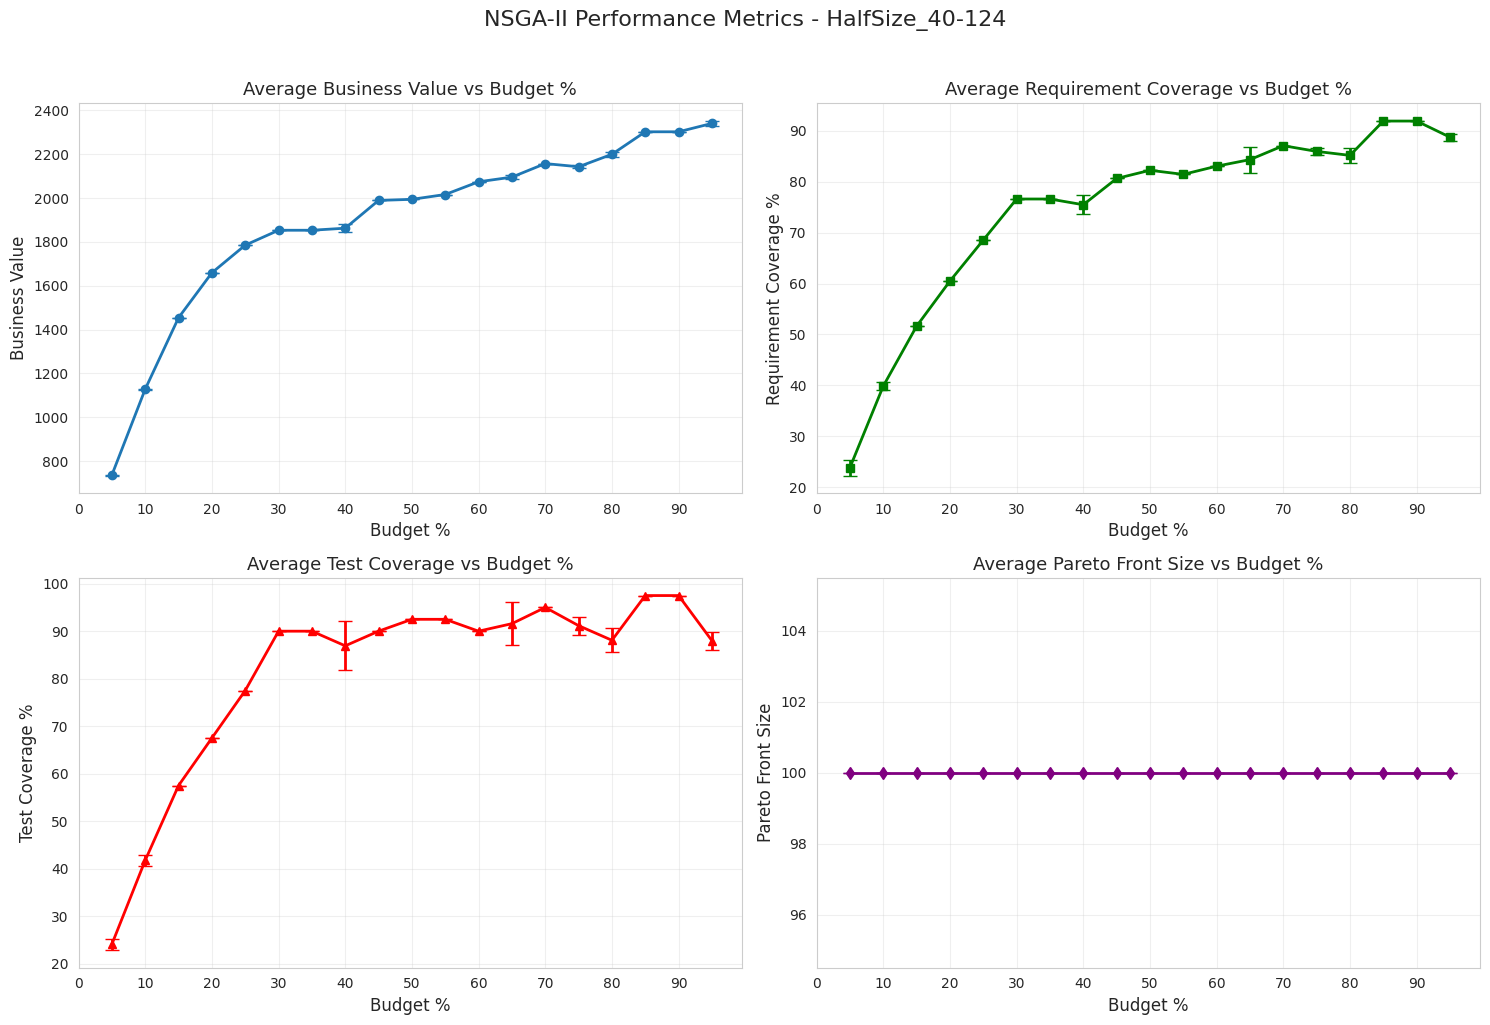

In [ ]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'NSGA-II Performance Metrics - {DATASET_NAME}', fontsize=16, y=1.02)

# Business Value
axes[0, 0].errorbar(summary_df['Budget_%'], summary_df['avg_BV'],
                    yerr=summary_df['std_BV'], marker='o', capsize=5, linewidth=2)
axes[0, 0].set_xlabel('Budget %', fontsize=12)
axes[0, 0].set_ylabel('Business Value', fontsize=12)
axes[0, 0].set_title('Average Business Value vs Budget %', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 100, 10))

# Requirement Coverage
axes[0, 1].errorbar(summary_df['Budget_%'], summary_df['avg_req_cvg'],
                    yerr=summary_df['std_req_cvg'], marker='s', capsize=5, color='green', linewidth=2)
axes[0, 1].set_xlabel('Budget %', fontsize=12)
axes[0, 1].set_ylabel('Requirement Coverage %', fontsize=12)
axes[0, 1].set_title('Average Requirement Coverage vs Budget %', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 100, 10))

# Test Coverage
axes[1, 0].errorbar(summary_df['Budget_%'], summary_df['avg_test_cvg'],
                    yerr=summary_df['std_test_cvg'], marker='^', capsize=5, color='red', linewidth=2)
axes[1, 0].set_xlabel('Budget %', fontsize=12)
axes[1, 0].set_ylabel('Test Coverage %', fontsize=12)
axes[1, 0].set_title('Average Test Coverage vs Budget %', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(0, 100, 10))

# Pareto Front Size
axes[1, 1].errorbar(summary_df['Budget_%'], summary_df['avg_pareto_size'],
                    yerr=summary_df['std_pareto_size'], marker='d', capsize=5, color='purple', linewidth=2)
axes[1, 1].set_xlabel('Budget %', fontsize=12)
axes[1, 1].set_ylabel('Pareto Front Size', fontsize=12)
axes[1, 1].set_title('Average Pareto Front Size vs Budget %', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, 100, 10))

plt.tight_layout()
plt.savefig(f'{OUTPUT_PREFIX}_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Print final summary
print(f"\n{'='*60}")
print(f"EXPERIMENT COMPLETE: {DATASET_NAME}")
print(f"{'='*60}")
print(f"Total runs completed: {len(BUDGET_PERCENTAGES) * NUM_RUNS}")
print(f"\nFiles saved:")
print(f"  - Summary: {summary_file}")
print(f"  - Detailed: {detailed_file}")
print(f"  - Visualization: {OUTPUT_PREFIX}_metrics.png")
print(f"\nKey Findings:")
print(f"  - Max avg BV: {summary_df['avg_BV'].max():.2f} at {summary_df.loc[summary_df['avg_BV'].idxmax(), 'Budget_%']:.0f}% budget")
print(f"  - Max avg Req Coverage: {summary_df['avg_req_cvg'].max():.2f}% at {summary_df.loc[summary_df['avg_req_cvg'].idxmax(), 'Budget_%']:.0f}% budget")
print(f"  - Max avg Test Coverage: {summary_df['avg_test_cvg'].max():.2f}% at {summary_df.loc[summary_df['avg_test_cvg'].idxmax(), 'Budget_%']:.0f}% budget")


EXPERIMENT COMPLETE: HalfSize_40-124
Total runs completed: 570

Files saved:
  - Summary: halfsize_summary.csv
  - Detailed: halfsize_all_runs.csv
  - Visualization: halfsize_metrics.png

Key Findings:
  - Max avg BV: 2340.20 at 95% budget
  - Max avg Req Coverage: 91.94% at 85% budget
  - Max avg Test Coverage: 97.50% at 85% budget
